In [57]:
import params as par
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import matplotlib as mpl
import numba

In [106]:
"""Settings and Parameters"""

# Plot Settings
plt.rcParams.update(par.plot_params)


# Parameters
H0 = 67.
Ωb0 = 0.04968
Ωc0 = 0.26754
Ωɣ0 = 5.50234e-5
Ων0 = 3.74248e-5

Ωr0 = Ωɣ0 + Ων0
Ωm0 = Ωb0 + Ωc0
ΩΛ  = 1-(Ωb0 + Ωc0 + Ωɣ0)


z_rec = 1090
a_rec = 1/(1+z_rec)
a_eq  = Ωr0/Ωm0

# Numerical Settings
τ0 = .001 / (H0 * 1000)

k_low =  par.k_low
k_high= par.k_high

N = 100
K = 100
K_int = 10000

In [107]:
"""Background Cosmology"""

def tau_itgd(a):
    """conformal time integrand"""
    return  1/(a**2* H0 * np.sqrt(Ωm0*a**-3 + Ωr0*a**-4 + ΩΛ))

(τ_rec,_) = integrate.quad(tau_itgd,0,a_rec)
(τ_eq,_) = integrate.quad(tau_itgd,0,a_eq)
(τ_now,_) = integrate.quad(tau_itgd,0,1)
τr = 1/(np.sqrt(Ωm0/a_rec)*H0/2)
τs = 0.6*Ωm0**(.25) * Ωb0**(-.5)*a_rec**(.75)*(H0/100)**(-.5)*τr


α = np.sqrt(a_rec/a_eq)
a = lambda τ: a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
y = lambda τ: a(τ)/a_eq
ℋ = lambda τ: 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
yb = lambda τ: 1.68*y(τ)*Ωb0/Ωm0

Ωb = lambda τ: Ωb0 * a(τ)**-3.
Ωc = lambda τ: Ωc0 * a(τ)**-3.
Ωɣ = lambda τ: Ωɣ0 * a(τ)**-4.
Ων = lambda τ: Ων0 * a(τ)**-4.
Ωm = lambda τ: Ωm0 * a(τ)**-3.
Ωr = lambda τ: Ωr0 * a(τ)**-4.
ΩT = lambda τ: Ωm(τ) + Ωr(τ)
Ωd = lambda τ: Ωc(τ) + Ων(τ)

print(τs)

2.0862059032780998e-05


In [108]:
# Load data from 3-fluid.
τ = pickle.load(open( "data/tau_solve.p", "rb" ) )
τRK45 = pickle.load(open( "data/tau_solve.p", "rb" ) )
τ_list = τ
stepsizes = np.diff(τRK45)
k_list = pickle.load(open( "data/k_vals.p", "rb" ) )

k_list = np.linspace(par.k_low, par.k_high, par.K_SOLVE)


# Load gdm functions
wd_F = pickle.load(open( "data/w_d.p", "rb" ) )
Dwd_F = pickle.load(open( "data/Dw_d.p", "rb" ) )
cs2d_F = pickle.load(open( "data/cs2_d.p", "rb" ) )


δd0 = pickle.load(open( "data/delta_d_init.p", "rb" ) )
vd0 = pickle.load(open( "data/v_d_init.p", "rb" ) )
δɣ0 = pickle.load(open( "data/delta_g_init.p", "rb" ) )
vɣ0 = pickle.load(open( "data/v_g_init.p", "rb" ) )
Φ0 = pickle.load(open( "data/phi_init.p", "rb" ) )

In [109]:
"""Precompute Bessel Functions"""

l_low = 2
l_high = 1200

l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 1200, 20)])

L = len(l_list)
Cl = np.zeros(len(l_list))


k_list2  = np.linspace(k_low,k_high,K_int)

JLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec))
                for l in l_list])
DJLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True) 
    for l in l_list])


In [110]:
wd = wd_F
Dwd = Dwd_F
cs2d = cs2d_F
Y0 = np.zeros((5,K))
@numba.jit(nopython=True)
def DY(τ, Y):
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
        #compute background quantities
        ℋ = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
        a =  a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
        yb = 1.68*a*Ωb0/Ωr0

        Ωb = Ωb0 * a**-3.
        Ωɣ = Ωɣ0 * a**-4.
        Ωd = Ωc0 * a**-3. + Ων0 * a**-4.

        wd_j = np.interp(τ, τ_list, wd)
        Dwd_j = np.interp(τ, τ_list, Dwd)
        
        #interpolate cs2
        idx = np.searchsorted(τ_list, τ) - 1
        d = (τ - τ_list[idx]) / (τ_list[idx + 1] - τ_list[idx])
        cs2d_j = (1 - d) * cs2d[:,idx] + cs2d[:,idx + 1] * d

        f = vd*Ωd*(1+wd_j) + 4./3.*Ωɣ*vɣ +  Ωb*vɣ

        DΦ  = -ℋ*Φ + (3/2.*H0**2.*a**2/k_list)*f

        Dδɣ = -4./3.*k_list*vɣ + 4*DΦ
        Dvɣ = (-ℋ*yb*vɣ + k_list*δɣ/3)/(
            4./3. + yb) + k_list*Φ

        Dδd = -(1+wd_j)*(k_list*vd-3*DΦ) - 3*ℋ*(cs2d_j-wd_j)*δd
        Dvd = -ℋ*(1-3*wd_j)*vd - vd*Dwd_j/(1+wd_j) + k_list*δd*cs2d_j/(1+wd_j) + k_list*Φ
        dY = np.zeros((5,K))
        dY[0,:] = DΦ
        dY[1,:] = Dδɣ
        dY[2,:] = Dvɣ
        dY[3,:] = Dδd
        dY[4,:] = Dvd

        #return np.array([DΦ, Dδɣ, Dvɣ, Dδd, Dvd])
        return dY

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

In [111]:
@numba.jit(nopython=True)
def solve(): 
    Y = np.zeros((len(τRK45), 5, K))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τRK45[:-1]):
        #implement rK4:
        ss = stepsizes[i]
        k1 = ss*DY(τi,Y[i,:,:])
        k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2)
        k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2)
        k4 = ss*DY(τi+ss,Y[i,:,:]+k3)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y[-1,:,:]

In [112]:
k_grid = np.broadcast_to(k_list2,(L,K_int))
@numba.jit(nopython=True)
def get_Cl():
    # first compute mode evolution:
    Yf = solve()
    SW = Yf[0,:] + Yf[1,:]/4
    DOP = Yf[2,:]
    SWsd = SW*np.exp(-(k_list*τs)**2)
    DOPsd = DOP*np.exp(-(k_list*τs)**2)
    
    # get the power spectrum
    SWfill = np.interp(k_list2, k_list, SW)
    DOPfill = np.interp(k_list2, k_list, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 *T /k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    Cl_out = l_list*(l_list + 1)*Cl
    return -Cl_out

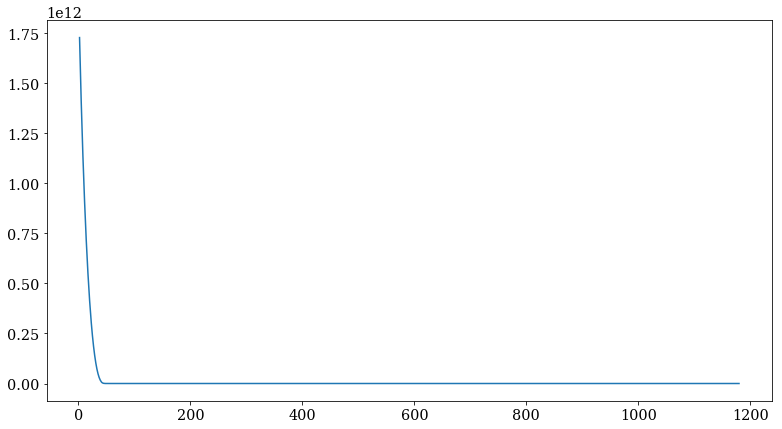

In [113]:
Cl = get_Cl()
plt.plot(l_list,Cl)

In [ ]:
# set the w basis
B = np.eye(N)
for n in range(N//2):
    s_n = np.sin((n+1)*np.pi*τ/τ[-1])
    c_n = np.cos(n*np.pi*τ/τ[-1])
    B[:,2*n] = s_n
    B[:,2*n+1] = c_n
#plt.imshow(B)

In [ ]:

# get fiducial power spectrum
wd = copy.deepcopy(wd_F)
cs2d = copy.deepcopy(cs2d_F)

Dwd = np.gradient(wd,τ)
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

Cl_F = get_Cl()

#perturb GDM functions
Θw = np.zeros(N)
Θcs2 = np.zeros((N,K))

Θw[3]=.0001
Θw[1]=.0001
wd = wd_F + B@Θw
cs2d = cs2d_F + Θcs2

Dwd = np.gradient(wd,τ)
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

Cl_per = get_Cl()

In [ ]:
plt.plot(τ, wd_F)
plt.plot(τ, wd, linestyle=':', linewidth=3)
plt.legend(['fiducial w', 'perturbed w'])
plt.show()

plt.plot(τ, wd_F-wd)
plt.legend(['perturbation'])
plt.show()

plt.semilogx(l_list, Cl_F)
plt.plot(l_list, Cl_per)
plt.legend(['fiducial w Cl', 'perturbed w Cl'])
plt.show()